In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
with open('/content/drive/My Drive/processed_corpus.json') as f:
    corpus = json.load(f)

In [4]:
len(corpus)

100000

In [ ]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

по контексту - слово

In [ ]:
sample_text = corpus[1]

# Реализуйте разделение предложения на примеры методом CBOW

In [ ]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    # CODE
    numtok = len(tokens)

    for ind in range(numtok):
        start = ind-window
        if start < 0: start = 0
        firstl = tokens[start:ind]
        lastl = tokens[ind+1:window+ind+1]
        if ind < window:
            first_list = [pad_token] * (window - ind)
            first_list += firstl
            firstl = first_list
        end = numtok - ind - 1
        if end < window:
            last_list = [pad_token] * (window - end)
            lastl += last_list
        splits.append((firstl, tokens[ind], lastl))
    return splits

In [ ]:
cbow_split(sample_text, window=2)

[(['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']),
 (['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']),
 (['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']),
 (['денежный', 'средство'], 'лицевой', ['счёт', 'либо']),
 (['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']),
 (['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']),
 (['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']),
 (['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']),
 (['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']),
 (['счёт', 'погашение'], 'кредит', ['PAD', 'PAD'])]

# Skipgram

# Реализуйте разделение предложения на примеры методом Skipgram

In [ ]:
def skipgram_split(tokens, window):
    numtok = len(tokens)
    splits = []
    
    # CODE
    for ind in range(numtok):
        y = tokens[ind]

        i = 1
        while ind-i>=0 and i <= window:
            x_back = tokens[ind-i]
            splits.append((x_back, y))
            i += 1

        j = 1
        while ind+j<numtok and j <= window:
            x_forward = tokens[ind+j]
            splits.append((x_forward, y))
            j += 1
    
    return splits

In [ ]:
splits = skipgram_split(sample_text, window=2)

In [ ]:
splits

In [5]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [6]:
len(word2index)

13076

In [ ]:
word2index['UNK']

1

In [ ]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [8]:
from torch.utils.data import Dataset, DataLoader

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [9]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        # CODE
        self.corpus = corpus
        self.word2index = word2index
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokens):
        
        # CODE

        splits = []
        numtok = len(tokens)
        for ind in range(numtok):
            y = tokens[ind]

            i = 1
            while ind-i>=0 and i <= self.window:
                x_back = tokens[ind-i]
                splits.append((x_back, y))
                i += 1

            j = 1
            while ind+j<numtok and j <= self.window:
                x_forward = tokens[ind+j]
                splits.append((x_forward, y))
                j += 1

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]
        
        return context, central_word

In [10]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:02<00:00, 43594.49it/s]


In [15]:
BATCH_SIZE = 512

In [16]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [17]:
len(dataset_loader) # number of batches

5827

In [18]:
for x, y in dataset_loader:
  break

In [19]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

# Мы будем учить модель Skipgram
Реализуйте ее

In [13]:
# CODE
class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [20]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [21]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [ ]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [ ]:
x.shape

torch.Size([512])

# Допишите обучалку

In [11]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [22]:
epochs = 3
EMBEDDING_DIM = 20
losses = []


model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE) # CODE

for n_epoch in range(epochs):
    try:
        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
        
        for x, y in dataset_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            preds = model(x) #прогоняем данные через модель

            loss = criterion(preds, y) #считаем значение функции потерь  
            
            loss.backward() #считаем градиенты 
            optimizer.step() #обновляем веса 
            
            # CODE
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [00:54<00:00, 54322.70it/s, loss=7.11]


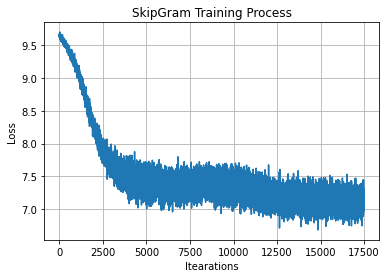

In [23]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [24]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [25]:
embedding_matrix = model.in_embedding.weight.detach()

In [26]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    # CODE
    # добавила exceptы для подсчета близости по корпусу для оценки
    try:
        i1 = token2id[word1]
    except:
        word1 = "UNK"
        i1 = token2id[word1]
    
    try:
        i2 = token2id[word2]
    except:
        word2 = "UNK"
        i2 = token2id[word2]

    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

на самом деле она для эмбеддингов может быть и отрицательная то есть в итоге от -1 до 1

In [27]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.7892816662788391

In [28]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.5934417843818665

In [29]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.41577595472335815

In [30]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.671994149684906

In [ ]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "мвд" равна 0.517'

In [ ]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [ ]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [ ]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix.cpu())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.001s...
[t-SNE] Computed neighbors for 13076 samples in 3.805s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 96.8800812, gradient norm = 0.0001001 (50 iterations in 13.322s)
[t-SNE] Iteration 100: error = 96.8968277, gradient norm = 0.0000208 (50 iterations in 16.288s)
[t-SNE] Iteration 150: error = 96.8965836, gradient norm = 0.0000089 (50 iterations in 13.862s)
[t-SNE] Iteration 200: error = 96.8965454, gradient norm = 0.0000090 (50 iterations in 9.456s)
[t-SNE] Iteration 250: error = 96.8966293, gradient norm = 0.0000121 (50 iterations in 6.922s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.896629
[t-SNE] Iteration 300: error = 4.3998461, gradient norm = 0.0015262 (50 iterations in 10.070s)
[t-SNE] Iteration 350: error = 4.0823355, gradient norm = 0.0005546 (50 iterations in 7.665s)
[t-SNE] Iteration 400: error = 3.9345298, gradient norm = 0.0003300 (50 iterations in 7.058s)
[t-SNE] Iteration 450: error = 3.8466458, gradient norm = 0.0002239 (50 iterations in 6.883s)
[t-SNE] Iteration 500: error = 3.7860625, gradient norm = 0.0001660 

In [ ]:
top_words = [a for a,_ in top_sorted_freq]

In [ ]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

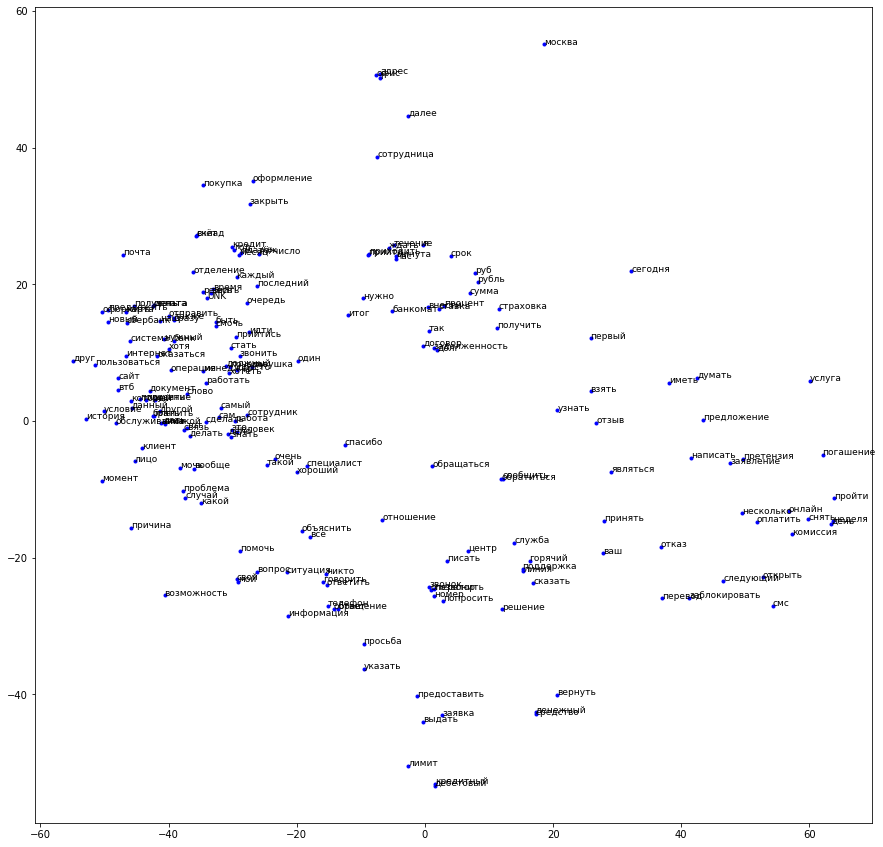

In [ ]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x, y, word, fontsize=9)
plt.show()

### корпус для оценки качества эмбеддингов

In [36]:
import pandas as pd

In [37]:
test_corp = pd.read_csv('https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv', sep='\t')

In [38]:
test_corp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   # Word1        965 non-null    object 
 1   Word2          965 non-null    object 
 2   Average Score  965 non-null    float64
dtypes: float64(1), object(2)
memory usage: 22.7+ KB


In [39]:
test_corp.head()

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23


убираю pos

In [40]:
test_corp["# Word1"] = test_corp["# Word1"].str.split("_", n = 1, expand = True)[0]
test_corp["Word2"] = test_corp["Word2"].str.split("_", n = 1, expand = True)[0]
test_corp.head()

,# Word1,Word2,Average Score
0,авария,бедствие,6.15
1,август,месяц,2.85
2,авиация,полет,6.77
3,автомобиль,гудок,1.85
4,автомобиль,автострада,1.23


In [41]:
def get_cos(row):
      return cos_sim(embedding_matrix, word2index, row["# Word1"], row["Word2"])

In [ ]:
test_corp["my_embed"] = test_corp.apply(lambda x: get_cos(x), axis=1)

In [ ]:
test_corp.head()

,# Word1,Word2,Average Score,my_embed
0,авария,бедствие,6.15,0.617345
1,август,месяц,2.85,0.560760
2,авиация,полет,6.77,1.000000
3,автомобиль,гудок,1.85,0.335222
4,автомобиль,автострада,1.23,0.613986


нормализация Average Score из датасета к отрезку от 0 до 1

In [42]:
from sklearn import preprocessing

In [43]:
scores = np.array(test_corp["Average Score"])

In [44]:
scores.shape

(965,)

In [45]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

In [46]:
test_scores = min_max_scaler.fit_transform(scores.reshape(-1, 1)).squeeze()

In [47]:
test_scores.shape

(965,)

mse между косинусными расстояниями по моим эмбеддингам и средними скорами из датасета для сравнения

In [ ]:
test_scores[:5]

array([ 0.23 , -0.43 ,  0.354, -0.63 , -0.754])

In [ ]:
test_corp[test_corp["my_embed"]<0] # есть отрицательные

,# Word1,Word2,Average Score,my_embed
180,дискуссия,спор,8.69,-0.021841


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_scores, test_corp["my_embed"])

In [ ]:
mse

1.0867730509110645

## эксперименты

1 увеличить EMBEDDING_DIM до стандартного 300

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [32]:
epochs = 3
EMBEDDING_DIM = 300
losses = []

model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)

for n_epoch in range(epochs):
    try:
        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
        for x, y in dataset_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            preds = model(x) #прогоняем данные через модель

            loss = criterion(preds, y) #считаем значение функции потерь  
            
            loss.backward() #считаем градиенты 
            optimizer.step() #обновляем веса 
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [01:42<00:00, 28975.17it/s, loss=8.23]


In [33]:
embedding_matrix = model.in_embedding.weight.detach()

In [48]:
test_corp["my_embed300"] = test_corp.apply(lambda x: get_cos(x), axis=1)

In [49]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_scores, test_corp["my_embed300"])
mse

0.7080696995447677

mse улучшилось!

### Skipgram with Negative Sampling 

попробую написать негативное семплирование

отрубилось gpu :(

так что тут только половина

Unigram Model

In [50]:
from collections import defaultdict

wordFreq = defaultdict(int)

for document in corpus:
    for word in document:
        wordFreq[word] += 1

frequencies to probabilities

In [51]:
totalWordsFreq = sum([freq for freq in wordFreq.values()])
print(totalWordsFreq)
wordProb = {word:(freq/totalWordsFreq) for word, freq in wordFreq.items()}

895780


In [52]:
len(wordProb)

13076

In [ ]:

als = 0
for key in wordProb:
  als += wordProb[key]
print(als)

1.0000000000000493


добавить негативные примеры

new dataset class

In [ ]:
class SkipgramNegSamplingDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        # CODE
        self.corpus = corpus
        self.word2index = word2index
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokens):
        splits = []
        numtok = len(tokens)
        for ind in range(numtok):
            y = tokens[ind]

            i = 1
            while ind-i>=0 and i <= self.window:
                x_back = tokens[ind-i]
                splits.append((x_back, y)) 
                i += 1

            j = 1
            while ind+j<numtok and j <= self.window:
                x_forward = tokens[ind+j]
                splits.append((x_forward, y))
                j += 1

        return splits
    
    def generate_negative_sample(self):  
        raz, dvaz = [np.random.choice(list(self.word2index.values()), size=len(self.data)*10) for _ in range(2)]
        return zip(raz, dvaz)

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)
            self.data.extend(skipgram_examples)
        
        negative = set()
        n_neg = 0

        pbar = tqdm(total = len(self.data)+1)
        while n_neg < len(self.data):
            new_neg = set(self.data) - set(self.generate_negative_sample())
            n_neg += len(new_neg)
            negative |= new_neg
            pbar.update(len(new_neg))
        
        res = set(zip(self.data, np.ones(len(self.data), dtype=int)))
        res |= set(zip(negative, np.zeros(len(negative), dtype=int)))
        
        self.data = list(res)
        pbar.close()

    def __getitem__(self, idx):
        
        # CODE
        context_and_word, prob = self.data[idx]
        x = torch.LongTensor([context_and_word])
        return x, prob

In [ ]:
dataset_with_neg = SkipgramNegSamplingDataset(corpus, word2index, wordProb)



  0%|          | 0/100000 [00:00<?, ?it/s]

  4%|▍         | 4210/100000 [00:00<00:02, 42096.33it/s]

  8%|▊         | 8420/100000 [00:00<00:02, 41245.55it/s]

 13%|█▎        | 12546/100000 [00:00<00:02, 40047.14it/s]

 17%|█▋        | 16555/100000 [00:00<00:02, 39919.22it/s]

 21%|██        | 20557/100000 [00:00<00:01, 39949.99it/s]

 25%|██▍       | 24554/100000 [00:00<00:01, 39837.00it/s]

 29%|██▊       | 28539/100000 [00:00<00:01, 38938.56it/s]

 32%|███▏      | 32437/100000 [00:00<00:01, 37245.66it/s]

 36%|███▌      | 36176/100000 [00:00<00:01, 37107.30it/s]

 40%|████      | 40106/100000 [00:01<00:01, 37757.71it/s]

 44%|████▍     | 43891/100000 [00:01<00:01, 37718.17it/s]

 48%|████▊     | 47843/100000 [00:01<00:01, 38255.09it/s]

 52%|█████▏    | 51674/100000 [00:01<00:01, 37664.97it/s]

 56%|█████▌    | 55903/100000 [00:01<00:01, 39031.78it/s]

 60%|█████▉    | 59813/100000 [00:01<00:01, 37092.33it/s]

 64%|██████▍   | 63808/100000 [00:01<00:00, 37911.18it/s]

 68%|██████▊

In [ ]:
BATCH_SIZE = 512

In [ ]:
dataset_loader_with_neg = DataLoader(dataset_with_neg, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
for x, y in dataset_loader_with_neg:
  break

In [ ]:
x[:5]

tensor([[[  45, 1198]],

        [[3810,  721]],

        [[ 892,  399]],

        [[1068,  854]],

        [[  60, 8324]]])

In [ ]:
y[:5]

tensor([0, 0, 0, 1, 0])

In [ ]:
x.shape

torch.Size([512, 1, 2])

In [ ]:
x[:5].squeeze()# .shape

tensor([[  45, 1198],
        [3810,  721],
        [ 892,  399],
        [1068,  854],
        [  60, 8324]])

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов